In [1]:
#importing the libraries
import tensorflow as tf
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


In [2]:
#preprocessing the data 
def get_three_classes(x, y):
    indices_0, _ =np.where(y == 0.)
    indices_1, _ =np.where(y == 1.)
    indices_2, _ =np.where(y == 2.)
    
    indices = np.concatenate([indices_0, indices_1, indices_2], axis = 0 )
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace = False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y 

In [3]:
#loading the dataset 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


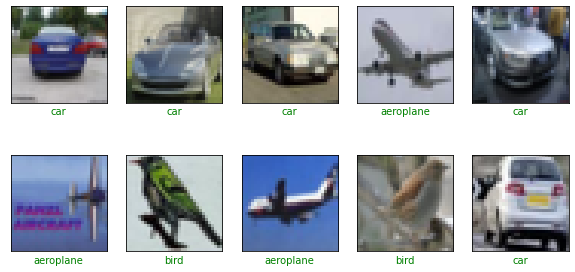

In [4]:
#visualising the data 
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(x.shape[0], 10, replace = False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize = (10, 5))
    for i in range(10):
        plt.subplot(2, 5, 1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green'if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color = col)
    plt.show()
    
show_random_examples(x_train, y_train, y_train)

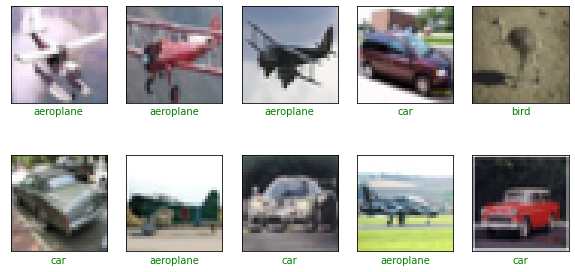

In [5]:
show_random_examples(x_test, y_test, y_test)

In [8]:
#creating the CNN Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation = 'relu', padding = 'same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation = 'relu'))
        model.add(MaxPooling2D(pool_size = 2))
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape = (32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation = 'softmax'))
    
    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam', metrics = ['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

In [15]:
#training the model
h = model.fit(
    x_train/255. , y_train,
    validation_data = (x_test/255. , y_test),
    epochs = 10, batch_size = 128,
    callbacks = [ 
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3 ),
        tf.keras.callbacks.ModelCheckpoint('model_{val_accuracy: .3f}.h5', save_best_only = True, save_weights_only = False, monitor = 'val_accuracy')
    ]
)

Epoch 1/10
118/118 [==============================] - 119s 1s/step - loss: 0.3074 - accuracy: 0.8803 - val_loss: 0.5189 - val_accuracy: 0.7973
Epoch 2/10
118/118 [==============================] - 105s 892ms/step - loss: 0.2862 - accuracy: 0.8903 - val_loss: 0.3311 - val_accuracy: 0.8763
Epoch 3/10
118/118 [==============================] - 108s 916ms/step - loss: 0.2746 - accuracy: 0.8948 - val_loss: 0.3888 - val_accuracy: 0.8550
Epoch 4/10
118/118 [==============================] - 91s 772ms/step - loss: 0.2539 - accuracy: 0.9035 - val_loss: 0.3108 - val_accuracy: 0.8900
Epoch 5/10
118/118 [==============================] - 91s 770ms/step - loss: 0.2463 - accuracy: 0.9067 - val_loss: 0.2971 - val_accuracy: 0.8907
Epoch 6/10
118/118 [==============================] - 91s 774ms/step - loss: 0.2419 - accuracy: 0.9062 - val_loss: 0.2875 - val_accuracy: 0.8943
Epoch 7/10
118/118 [==============================] - 91s 774ms/step - loss: 0.2325 - accuracy: 0.9111 - val_loss: 0.3116 - val_ac

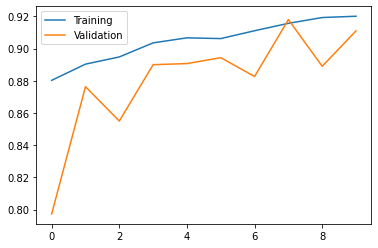

In [16]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label = 'Training')
plt.plot(range(len(accs)), val_accs, label = 'Validation')
plt.legend()
plt.show()

In [19]:
preds = model.predict(x_test/255.)

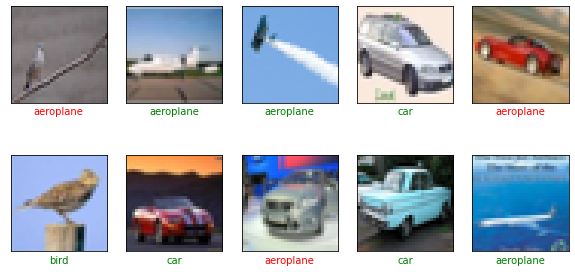

In [21]:
show_random_examples(x_test, y_test, preds)